#Section 4 project
##딥러닝을 이용한 영화 추천 알고리즘

##주제 선택 배경  
- 요즘 넷플릭스를 필두로 OTT 시장이 급격하게 성장함에 따라, 많은 컨텐츠 소유기업(디즈니, 워너브라더스 등)들도 자체적인 OTT서비스를 내놓기 시작했다. 각각의 서비스는 대중이 서비스를 계속 구독하도록 하기 위해 유저인터페이스에 적용되는 다양한 추천알고리즘을 운용하고 있다.
- 고전영화부터 신작영화까지 다양한 영화들이 스트리밍 시스템에 업데이트 되고 있으며, 사용자들에게 추천알고리즘을 띄우기 전 해당 영화가 추천 할만한 수준의 완성도를 가지고 있는 지를 예측하는 시스템을 만들 것이다.
- 스트리밍 이용자가 추천영화를 봤을 때, 느끼는 만족도가 더 커질 수록 추천알고리즘을 이용하는 경우가 더 많아질 것이며, 이는 서비스의 이용률 증가로 이어질 것이다. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 선정  
kaggle에 올라온 IMDB(미국 영화 데이터베이스) 자료를 다운

In [ ]:
df_movies = pd.read_csv('/content/drive/My Drive/Code/IMDb movies.csv')
df_ratings = pd.read_csv('/content/drive/My Drive/Code/IMDb ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_ratings = df_ratings[['imdb_title_id','males_18age_avg_vote','males_30age_avg_vote','females_18age_avg_vote','females_30age_avg_vote']]

In [ ]:
df_movies.shape

(85855, 22)

In [ ]:
df_movies = df_movies.merge(df_ratings,on='imdb_title_id')

In [ ]:
df_movies.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics', 'males_18age_avg_vote',
       'males_30age_avg_vote', 'females_18age_avg_vote',
       'females_30age_avg_vote'],
      dtype='object')

In [ ]:
df_movies.shape

(85855, 26)

In [ ]:
df_movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,males_18age_avg_vote,males_30age_avg_vote,females_18age_avg_vote,females_30age_avg_vote
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0,5.9,5.6,5.9,5.7
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0,6.2,6.0,5.9,6.2
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0,5.5,5.9,5.8,5.8
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0,5.2,4.9,5.7,5.5
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0,7.0,7.0,7.0,7.3


In [ ]:
df_movies.shape

(85855, 26)

## 문제 정의

해당 dataset에서 관람자의 만족도를 가장 잘 반영하는 feature는 avg_vote(평균 평점 1~10)일 것이다. 분포를 살펴보면,

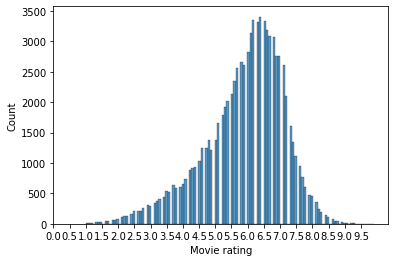

In [ ]:
sns.histplot(data=df_movies.avg_vote)
plt.xlabel('Movie rating')
plt.xticks(np.arange(0, 10, step=0.5));

rating 6.0점을 의 벽을 기준으로 그저그런 영화와 잘 만든영화가 구분되는 것을 관찰 할 수 있다. 따라서 입력되는 영화의 정보들을 모델에 학습시켜, 6.0점이 넘을 것으로 예상된다면 True(추천), 그렇지 않다면 False(비추천)으로 분류하는 classification 알고리즘을 만들어보자.  
(baseline 모델은 모델링 파트 직전에 만들 예정) 

## EDA & Feature Engineering

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85855 entries, 0 to 85854
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imdb_title_id           85855 non-null  object 
 1   title                   85855 non-null  object 
 2   original_title          85855 non-null  object 
 3   year                    85855 non-null  object 
 4   date_published          85855 non-null  object 
 5   genre                   85855 non-null  object 
 6   duration                85855 non-null  int64  
 7   country                 85791 non-null  object 
 8   language                85022 non-null  object 
 9   director                85768 non-null  object 
 10  writer                  84283 non-null  object 
 11  production_company      81400 non-null  object 
 12  actors                  85786 non-null  object 
 13  description             83740 non-null  object 
 14  avg_vote                85855 non-null

먼저 결측치가 과다하게 많은 budget, usa_gross_income, worlwide_gross_income, metascore는 feature에서 제거한다.

추가적으로 모델 training에서 제거할 feature들은 다음과 같다.
- votes(평점 득표 수)의 경우 대중성을 반영하는 좋은 척도가 될 수 있지만, leakage issue를 유발할 수 있으므로 삭제한다. 
- title, original_title은 고유값이므로 제외한다.
- date_published정보는 year로 대체 가능
- language는 country로 대체 가능
- 이 모델에서는 평점(Rating)만 활용할 것이므로, review 정보는 제외한다(reviews_from_critics)


In [ ]:
df_movies = df_movies.drop(columns = ['budget','usa_gross_income','worlwide_gross_income','metascore',
                                      'reviews_from_critics','title','original_title','date_published','language'])

데이터의 feature를 더 자세히 살펴보며 전처리를 진행해보자

In [ ]:
df_movies['year'].unique()

array([1894, 1906, 1911, 1912, 1919, 1913, 1914, 1915, 1916, 1917, 1918,
       1920, 1921, 1924, 1922, 1923, 1925, 1926, 1935, 1927, 1928, 1983,
       1929, 1930, 1932, 1931, 1937, 1938, 1933, 1934, 1936, 1940, 1939,
       1942, 1943, 1941, 1948, 1944, 2001, 1946, 1945, 1947, 1973, 1949,
       1950, 1952, 1951, 1962, 1953, 1954, 1955, 1961, 1956, 1958, 1957,
       1959, 1960, 1963, 1965, 1971, 1964, 1966, 1968, 1967, 1969, 1976,
       1970, 1979, 1972, 1981, 1978, 2000, 1989, 1975, 1974, 1986, 1990,
       2018, 1977, 1982, 1980, 1993, 1984, 1985, 1988, 1987, 2005, 1991,
       2002, 1994, 1992, 1995, 2017, 1997, 1996, 2006, 1999, 1998, 2007,
       2008, 2003, 2004, 2010, 2009, 2011, 2013, 2012, 2016, 2015, 2014,
       2019, 2020, '2012', '2015', '2009', '2013', '2018', '2014', '2017',
       '2011', '2016', '1981', '1975', '2010', '1984', '2007', '2006',
       '2001', '2004', '1979', '2019', '1967', '1978', '2003', '2005',
       '1969', '1990', '1983', '2002', '1996', '2008'

'TV movie 2019' 라는 특이 data가 보인다. 2019로 바꿔주자

In [ ]:
df_movies['year'] = df_movies['year'].replace('TV Movie 2019',2019)

In [ ]:
# 'year' column을 object 에서 numeric으로 변경
df_movies['year'] = pd.to_numeric(df_movies['year'])

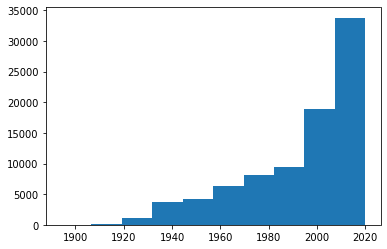

In [ ]:
plt.hist(df_movies['year']);

최신 트렌드 반영을 위하여, 1990년대 이후의 영화만 집계하도록 한다.  
###**이번 프로젝트의 경우 데이터 처리시간이 매우 오래 걸려 2017년 이후 영화로 한정한다.

In [ ]:
#year 1990 이상만 다시 저장
df_movies = df_movies[(df_movies.year >= 2017)]

In [ ]:
df_movies = df_movies.dropna(subset=['director','writer','actors','country','production_company','reviews_from_users','description'])

폐쇄적인 취향을 가지고 있는 india 영화도 모델의 성능을 위해서 제거한다.

In [ ]:
df_movies = df_movies[~df_movies.country.str.contains("India")]
#df_movies = df_movies[~df_movies.country.str.contains("China")]

In [ ]:
df_movies.shape

(7115, 17)

Duration(상영시간의 경우), 영화가 너무 길면, 거부감을 발생시킬 수 있으므로, 99.8 percentile로 극단치를 제거하도록 한다. 

In [ ]:
df_movies.duration.describe()

count    7115.000000
mean       99.521855
std        17.004916
min        44.000000
25%        89.000000
50%        97.000000
75%       108.000000
max       354.000000
Name: duration, dtype: float64

In [ ]:
temp1 = np.percentile(df_movies.duration,99.8)
temp2 = np.percentile(df_movies.duration,0.02)

In [ ]:
df_movies = df_movies[(df_movies.duration <= temp1) & (df_movies.duration >= temp2)]

In [ ]:
df_movies.nunique()

imdb_title_id             7098
year                         4
genre                      411
duration                   124
country                    975
director                  6175
writer                    6735
production_company        4952
actors                    7097
description               7093
avg_vote                    83
votes                     3122
reviews_from_users         595
males_18age_avg_vote        90
males_30age_avg_vote        80
females_18age_avg_vote      91
females_30age_avg_vote      91
dtype: int64

남은 feature들의 경우 대부분 고유명사(이름, 명칭) 이므로 매우 큰 cardinality를 가지고 있다. feature 별로 cardinality를 줄일 수 있는 방법을 가정해보고 적용해보자

In [ ]:
df_movies.genre

15675                           Drama
32465    Animation, Adventure, Comedy
42166                   Comedy, Drama
42695                          Horror
43366         Drama, Sci-Fi, Thriller
                     ...             
85838    Animation, Adventure, Family
85839                  Action, Comedy
85842     Animation, Adventure, Crime
85846                             War
85851                   Comedy, Drama
Name: genre, Length: 7098, dtype: object

Genre의 경우 ', ' 를 나눠서 cadinality를 다시 계산 가능하다

In [ ]:
genres = []
for i in df_movies.genre:
  temp = i.split(', ')
  for j in temp:
    if j in genres:
      continue
    else:
      genres.append(j)

In [ ]:
#Genre의 실제 cardinality
genres

['Drama',
 'Animation',
 'Adventure',
 'Comedy',
 'Horror',
 'Sci-Fi',
 'Thriller',
 'Crime',
 'Mystery',
 'Action',
 'War',
 'Fantasy',
 'History',
 'Romance',
 'Biography',
 'Family',
 'Western',
 'Music',
 'Musical',
 'Sport',
 'Reality-TV']

country도 마찬가지로 처리

In [ ]:
countries = []
for i in df_movies.country:
  temp = i.split(', ')
  for j in temp:
    if j in countries:
      continue
    else:
      countries.append(j)

각 genre와 country 에 해당하는 binary column을 만들어 encoding 효과를 만들어 낼 수 있다.

In [ ]:
for i in genres:
  df_movies[i] = np.where(df_movies['genre'].str.contains(i),1,0)
for i in countries:
  df_movies[i] = np.where(df_movies['country'].str.contains(i),1,0)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [ ]:
df_movies[list(df_movies.columns[12:])]

,reviews_from_users,males_18age_avg_vote,males_30age_avg_vote,females_18age_avg_vote,females_30age_avg_vote,Drama,Animation,Adventure,Comedy,Horror,Sci-Fi,Thriller,Crime,Mystery,Action,War,Fantasy,History,Romance,Biography,Family,Western,Music,Musical,Sport,Reality-TV,France,Iran,USA,Canada,Japan,Australia,China,Hong Kong,UK,Malaysia,Portugal,Denmark,Russia,Indonesia,...,Trinidad and Tobago,Mongolia,Panama,Jamaica,Sri Lanka,Armenia,Senegal,The Democratic Republic Of Congo,Venezuela,Montenegro,Kosovo,Martinique,Maldives,Djibouti,Brunei,Zambia,Reunion,Ethiopia,Jordan,Costa Rica,Belarus,Ghana,Kazakhstan,Bolivia,Guadeloupe,Algeria,Malawi,Holy See (Vatican City State),Serbia and Montenegro,Azerbaijan,British Virgin Islands,Cape Verde,Zimbabwe,Uzbekistan,Rwanda,Yemen,Mozambique,Syria,Bhutan,Macao
15675,81.0,7.3,6.7,6.9,6.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32465,2.0,9.6,7.5,8.6,9.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42166,4.0,7.0,6.7,9.0,4.2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42695,46.0,6.0,5.4,6.2,5.7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
43366,206.0,4.9,4.8,5.2,4.9,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85838,28.0,5.2,5.4,6.4,6.4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85839,388.0,5.1,5.1,5.4,5.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85842,1.0,6.9,6.9,NaN,NaN,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85846,29.0,3.5,3.7,5.2,5.7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


director(감독), writer(각본), actor(배우)의 경우, 이름값이 들어가 있으므로 cardinality를 다루기가 매우 까다롭다. 이번 모델에서는 다음과 같은 가정을 한다.

1. dataset에서 director, writer, actor가 감독,각본,출연한 영화가 많을수록 score가 올라간다.
2. 영화의 맡은 director, writer는 이름 대신 그 이름이 가지고 있는 score로 대체(공동 감독, 각본일 경우, max로 한다.). actor의 경우 출연자들 score의 평균으로 대체한다.

In [ ]:
#director, writer, actor 이름들을 가지고 있는 raw list를 생성

directors = []
writers = []
actors = []
production_companies = []

for i in df_movies.director:
  temp = i.split(', ')
  for j in temp:
    directors.append(j)
    
for i in df_movies.writer:
  temp = i.split(', ')
  for j in temp:
    writers.append(j)

for i in df_movies.actors:
  temp = i.split(', ')
  for j in temp:
    actors.append(j)

for i in df_movies.production_company:
  temp = i.split(', ')
  for j in temp:
    production_companies.append(j)

In [ ]:
# dataset에서 등장한 횟수(score)를 이름에 매칭시키는 dictionary로 저장

from collections import Counter

#sorted(Counter(directors).values(),reverse=True)

director_score_list = Counter(directors) 
writer_score_list = Counter(writers)
actor_score_list = Counter(actors)
production_companies_list = Counter(production_companies)

In [ ]:
#director_score_list

In [ ]:
#해당 dataset의 이름을 score로 교체

df_movies['director_score'] = [max(director_score_list[j] for j in i.split(', ')) for i in df_movies.director]
df_movies['writer_score'] = [max(writer_score_list[j] for j in i.split(', ')) for i in df_movies.writer]
df_movies['actor_score'] = [ sum(actor_score_list[j] for j in i.split(', ')) / len(i.split(', ')) for i in df_movies.actors]
df_movies['production_company_score'] = [production_companies_list[i] for i in df_movies.production_company]

In [ ]:
#encoding이 완료된 feature들을 제거
df_movies = df_movies.drop(columns=['director','writer','production_company','actors','genre','country'])

In [ ]:
df_movies.head()

,imdb_title_id,year,duration,description,avg_vote,votes,reviews_from_users,males_18age_avg_vote,males_30age_avg_vote,females_18age_avg_vote,females_30age_avg_vote,Drama,Animation,Adventure,Comedy,Horror,Sci-Fi,Thriller,Crime,Mystery,Action,War,Fantasy,History,Romance,Biography,Family,Western,Music,Musical,Sport,Reality-TV,France,Iran,USA,Canada,Japan,Australia,China,Hong Kong,...,Sri Lanka,Armenia,Senegal,The Democratic Republic Of Congo,Venezuela,Montenegro,Kosovo,Martinique,Maldives,Djibouti,Brunei,Zambia,Reunion,Ethiopia,Jordan,Costa Rica,Belarus,Ghana,Kazakhstan,Bolivia,Guadeloupe,Algeria,Malawi,Holy See (Vatican City State),Serbia and Montenegro,Azerbaijan,British Virgin Islands,Cape Verde,Zimbabwe,Uzbekistan,Rwanda,Yemen,Mozambique,Syria,Bhutan,Macao,director_score,writer_score,actor_score,production_company_score
15675,tt0069049,2018,122,A Hollywood director emerges from semi-exile w...,6.8,5887,81.0,7.3,6.7,6.9,6.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.266667,3
32465,tt0137204,2017,83,Simple-minded Joseph Briteman breaks a golden ...,8.8,264,2.0,9.6,7.5,8.6,9.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2.133333,1
42166,tt0326716,2017,113,"Alienated, hopeful-filmmaker Pat Johnson's epi...",6.1,304,4.0,7.0,6.7,9.0,4.2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1.600000,1
42695,tt0339736,2017,98,"The sadistic tale of a lonely, mentally handic...",5.5,2914,46.0,6.0,5.4,6.2,5.7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2.333333,1
43366,tt0360556,2018,100,"In a terrifying care-free future, a young man,...",4.9,16882,206.0,4.9,4.8,5.2,4.9,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2.066667,2


In [ ]:
df_movies.to_csv('processed.csv')

In [ ]:
#런타임 초기화시 이 셀에서부터
df_movies = pd.read_csv('processed.csv')
df_movies = df_movies.drop(columns=['Unnamed: 0'])

In [ ]:
#df_movies.head()

In [ ]:
#먼저 toysize로 실행
#df_movies = df_movies.head(5000)

모델을 만들기에 앞서, 무작위로 추천/비추천을 했을 때의 정답률을 확률적으로 가정하기 위해, baseline 모델의 점수를 확인해보자

In [ ]:
#이번 모델은 모든 사용자의 점수를 기준으로 만든다.
target = 'avg_vote'

In [ ]:
df_movies = df_movies.dropna(subset=[target])

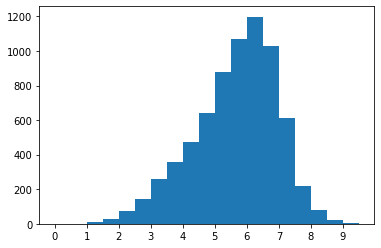

In [ ]:
plt.hist(df_movies.avg_vote,bins=np.arange(0,10,0.5))
plt.xticks(np.arange(0, 10, step=1));

추천 classification을 위해 6.0 이상은 True 그 이하는 False로 값을 변경해준다.

In [ ]:
#rating 6.5 이상은 true, 그 이하는 false로 avg_vote값을 변경 
df_movies[target] = (df_movies[target] >= 6.0)
#df_movies[target].value_counts(normalize=True)

In [ ]:
df_movies[target].value_counts(normalize=True)

False    0.554522
True     0.445478
Name: avg_vote, dtype: float64

baseline의 점수는 55.4% 이다.

In [ ]:
#train, test 분리
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_movies, test_size=0.2, 
                              stratify=df_movies['avg_vote'], random_state=2)
train.shape, test.shape

((5678, 175), (1420, 175))

In [ ]:
#text input에 대한 데이터 따로 추출
X_train_text = train['description']
X_test_text = test['description']

In [ ]:
y_train = train[target]
y_test = test[target]

In [ ]:
#기타 영화 정보 데이터 추출 
X_train_info = train.drop(columns=['avg_vote','votes','imdb_title_id','description','reviews_from_users','males_18age_avg_vote','males_30age_avg_vote','females_18age_avg_vote','females_30age_avg_vote'])
X_test_info = test.drop(columns=['avg_vote','votes','imdb_title_id','description','reviews_from_users','males_18age_avg_vote','males_30age_avg_vote','females_18age_avg_vote','females_30age_avg_vote'])

In [ ]:
X_train_info.shape

(5678, 166)

##영화 이미지 업로드

먼저 인터넷에서 영화 포스터를 다운

In [ ]:
!pip install movieposters

     |████████████████████████████████| 122kB 5.9MB/s 
     |████████████████████████████████| 153kB 5.7MB/s 
     |████████████████████████████████| 5.5MB 7.4MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
#temp.index[temp['imdb_title_id'] == 'tt0147867']

In [ ]:
df_movies['imdb_title_id']

0       tt0069049
1       tt0137204
2       tt0326716
3       tt0339736
4       tt0360556
          ...    
7093    tt9896916
7094    tt9898858
7095    tt9900060
7096    tt9904802
7097    tt9911196
Name: imdb_title_id, Length: 7098, dtype: object

In [ ]:
#구글 드라이브 업로드 이후에는 사용 안함

# import movieposters as mp
# import urllib.request

# p = 1
# no_poster = []
# for i in df_movies['imdb_title_id']:    #해당 id로 영화의 포스터를 조회하여 다운받아 저장한다.
#   if p % 50 == 0:
#     print(p)
#   save_id = i
#   try:
#     link = mp.get_poster(id = i)
#   except:
#     print(i,'not exist')
#     no_poster.append(i)
#   urllib.request.urlretrieve(link, "/content/drive/MyDrive/Section4_poster/" + i + '_' + '0' + '.jpg')
#   p = p + 1

In [ ]:
from skimage import color, io
from skimage.transform import resize
import os

In [ ]:
len(train['imdb_title_id'])

5678

In [ ]:
#포스터 이미지 데이터를 저장할 matrix 선언
X_train_images = np.empty((len(train['imdb_title_id']),150,150,3))
X_test_images = np.empty((len(test['imdb_title_id']),150,150,3))

In [ ]:
#저장파일 불러올때는 실행안함

# p = 0
# for i in range(len(train['imdb_title_id'])):
#   if p % 50 == 0:
#     print(p)
#   file_name = train['imdb_title_id'].iloc[i] + '_0.jpg'
#   image_down = io.imread_collection(os.path.join('/content/drive/MyDrive/Section4_poster/', file_name)) #이미지를 저장한 구글 드라이브에서 다운로드
#   if len(image_down) == 0 or len(image_down[0].shape) == 2: #해당 이미지가 없거나 흑백일 경우, zero matrix로 저장
#     X_train_images[i] = np.zeros((150,150,3))
#   else:
#     poster_image = resize(image_down[0], (150, 150))  #(150 x 150 사이즈로 resize 진행
#     try:
#       X_train_images[i] = poster_image
#     except:
#       print(file_name)
#   p = p+1


# #test set에 대해서도 동일하게 진행
# for i in range(len(test['imdb_title_id'])):
#   if p % 50 == 0:
#     print(p)
#   file_name = test['imdb_title_id'].iloc[i] + '_0.jpg'
#   image_down = io.imread_collection(os.path.join('/content/drive/MyDrive/Section4_poster/', file_name))
#   if len(image_down) == 0 or len(image_down[0].shape) == 2:
#     X_test_images[i] = np.zeros((150,150,3))
#   else:
#     poster_image = resize(image_down[0], (150, 150))
#     X_test_images[i] = poster_image
#   p = p+1

In [ ]:
X_test_images.shape

(1420, 150, 150, 3)

In [ ]:
#저장 완료

# np.savez_compressed('/content/drive/My Drive/X_train_images2',X_train_images)
# np.savez_compressed('/content/drive/My Drive/X_test_images2',X_test_images)

In [ ]:
X_train_images = np.load('/content/drive/My Drive/X_train_images2.npz')

In [ ]:
X_train_images = X_train_images['arr_0']

In [ ]:
X_test_images = np.load('/content/drive/My Drive/X_test_images2.npz')
X_test_images = X_test_images['arr_0']

##1. 기타 영화정보를 처리하는 기본 신경망 architecture 만들기

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM
from keras.models import Model

info_input = tf.keras.Input(shape=(166,),name = 'movie_info')
X3 = Dense(64, activation='relu', input_shape=(166,))(info_input)
X3 = Dense(64, activation='relu')(X3)

model3 = Model(info_input,X3)

model3.summary()

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
movie_info (InputLayer)      [(None, 166)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                10688     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
Total params: 14,848
Trainable params: 14,848
Non-trainable params: 0
_________________________________________________________________


##2. description 정보 encoding 및 학습을 위한 NLP LSTM RNN 만들기

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_text)

X_train_text = tokenizer.texts_to_sequences(X_train_text)
X_test_text = tokenizer.texts_to_sequences(X_test_text)

In [ ]:
max = 1
for i in X_train_text:
  if max < len(i):
    max = len(i)
print(max)

for i in X_test_text:
  if max < len(i):
    max = len(i)
print(max)

74
74


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = max

X_train_text = pad_sequences(X_train_text, padding='post', maxlen=maxlen)
X_test_text = pad_sequences(X_test_text, padding='post', maxlen=maxlen)

In [ ]:
X_test_text.shape

(1420, 74)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

#glove_file 외부 코퍼스 파일을 사용
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(16952, 100)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM
from keras.models import Model
#model = Sequential()
#embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
#model.add(embedding_layer)
#model.add(LSTM(128))

text_input = tf.keras.Input(shape=(None,),name = 'synopsis')
X = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)(text_input)
X = LSTM(128)(X)

model1 = Model(text_input,X)

model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
synopsis (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1695200   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
Total params: 1,812,448
Trainable params: 117,248
Non-trainable params: 1,695,200
_________________________________________________________________


##3. 이미지를 학습하는 CNN 모델링 

In [ ]:
from keras.applications import VGG16
from tensorflow.keras import layers

image_input = tf.keras.Input(shape=(150, 150, 3), name='image')
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))(image_input)
X2 = layers.Flatten()(vgg16) 
X2 = layers.Dense(256, activation='relu')(X2)

model2 = Model(image_input,X2)

model2.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
Total params: 16,812,096
Trainable params: 16,812,096
Non-trainable params: 0
_________________________________________________________________


## 4. 세 가지 모델을 합쳐서 최종 모델을 만든다.

In [ ]:
concatenated = layers.concatenate([X, X2, X3], axis=-1)
output = layers.Dense(1, activation='sigmoid')(concatenated)
model = Model([text_input,image_input,info_input],output)
model.summary()

# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# concatenated = layers.concatenate([X, X2, X3], axis=-1)
# output = layers.Dense(1, activation='sigmoid')(concatenated)
# model = Model([text_input,image_input,info_input],output)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model = KerasClassifier(build_fn=model, verbose=0)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
synopsis (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 4, 4, 512)    14714688    image[0][0]                      
__________________________________________________________________________________________________
movie_info (InputLayer)         [(None, 166)]        0                                            
____________________________________________________________________________________________

##모델 컴파일 및 학습 진행

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
#저장파일 불러올때는 실행안함

model.fit([X_train_text, X_train_images,X_train_info], y_train, validation_split=0.2, epochs=30, batch_size=128)

Epoch 1/30
36/36 [==============================] - 32s 657ms/step - loss: 32.6284 - accuracy: 0.5451 - val_loss: 0.6661 - val_accuracy: 0.6171
Epoch 2/30
36/36 [==============================] - 15s 418ms/step - loss: 0.6760 - accuracy: 0.5914 - val_loss: 0.8586 - val_accuracy: 0.4560
Epoch 3/30
36/36 [==============================] - 15s 416ms/step - loss: 0.7051 - accuracy: 0.5691 - val_loss: 0.6284 - val_accuracy: 0.6673
Epoch 4/30
36/36 [==============================] - 15s 417ms/step - loss: 0.6661 - accuracy: 0.6024 - val_loss: 0.6244 - val_accuracy: 0.6461
Epoch 5/30
36/36 [==============================] - 15s 417ms/step - loss: 0.6437 - accuracy: 0.6303 - val_loss: 0.6708 - val_accuracy: 0.5863
Epoch 6/30
36/36 [==============================] - 15s 417ms/step - loss: 0.6153 - accuracy: 0.6614 - val_loss: 0.6771 - val_accuracy: 0.5924
Epoch 7/30
36/36 [==============================] - 15s 417ms/step - loss: 0.6439 - accuracy: 0.6411 - val_loss: 0.6054 - val_accuracy: 0.699

##Test set 성능 확인

In [ ]:
score = model.evaluate([X_test_text, X_test_images, X_test_info], y_test, verbose=1)

45/45 [==============================] - 2s 35ms/step - loss: 0.5636 - accuracy: 0.7014


In [ ]:
#model output 저장

#model.save('/content/drive/My Drive/multi_input.h5')

In [ ]:
# from sklearn.model_selection import GridSearchCV

# batch_size = [128]
# epochs = [30]
# param_grid = dict(batch_size=batch_size)

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1,cv=3)
# grid_result = grid.fit([X_train_text, X_train_images,X_train_info], y_train.values)

In [ ]:
X_train_text.shape

(5678, 74)

In [ ]:
y_predict = model.predict([X_test_text, X_test_images,X_test_info])

##classification report 확인

In [ ]:
y_predict[:10]

array([[0.7889965 ],
       [0.30325395],
       [0.07481921],
       [0.18998007],
       [0.45838776],
       [0.3765804 ],
       [0.08977081],
       [0.19491592],
       [0.1548462 ],
       [0.6622297 ]], dtype=float32)

In [ ]:
temp = [ i > 0.5 for i  in y_predict ] 

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test.values, temp))

              precision    recall  f1-score   support

       False       0.68      0.89      0.77       787
        True       0.77      0.47      0.59       633

    accuracy                           0.70      1420
   macro avg       0.72      0.68      0.68      1420
weighted avg       0.72      0.70      0.69      1420



In [ ]:
df_movies = pd.read_csv('/content/drive/My Drive/Code/IMDb movies.csv')
movie_names = df_movies['original_title'].loc[test.index]

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
test_temp = test.reset_index()

In [ ]:
test_temp['score'] = [ y_predict[i] for i in range(len(y_predict))]

In [ ]:
#분류상 상위 확률로 랭크된 영화들의 id를 조회하여, 어떤 영화인 지 찾아볼 수 있다.

test_temp.sort_values(by=['score'],ascending = False).imdb_title_id.head(20)

1380     tt6470924
759      tt4065552
359      tt4003440
1057     tt3409848
652      tt6559390
745     tt11777040
139      tt7282468
470      tt5618752
802      tt7985648
1021     tt6932818
1064    tt10883506
1373     tt4154796
41       tt9611484
728      tt6896536
1250     tt8956390
549      tt7666250
293      tt8161166
245      tt5591834
428      tt6125690
772      tt8726098
Name: imdb_title_id, dtype: object

##requirements.txt 저장

In [ ]:
pip freeze > requirements.txt

In [ ]:
pip list